# Project : Alternus Vera Iteration 1

#**Team: The Mean Squares**
* Jeyasri Subramanian [SJSU ID: 014510132]
* Subarna Chowdhury Soma [SJSU ID: 014549587]
* Pranav Lodha [SJSU ID: 009468121]
* Wasae Qureshi [SJSU ID: 014569880]

##**Contributions:**


1. Iteration 2 improvements to factor Credibility-and-Reliability **[Pranav]**
2. Iteration 2 improvements to factor Biases **[Wasae]**
3. Iteration 2 improvements to factor News Coverage **[Subarna]**
4. Iteration 2 improvements to factor Neural Micro-patterns-of-Misinformation **[Jeyasri]**
5. Data insights **[ Team]**


In [0]:
import pandas as pd
import numpy as np
import random
import csv
import os
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk

from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from scipy import sparse


import matplotlib.pyplot as mp
%matplotlib inline
# Code source: https://degravek.github.io/project-pages/project1/2017/04/28/New-Notebook/
# Dataset from Chakraborty et al. (https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Mount Google Drive


In [0]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset


In [0]:
! ls '/content/drive/My Drive/dataset/'

fake.csv  glove.6B  liar_dataset  News_dataset	stopwords.txt


# Column names
* Column 1: the ID of the statement ([ID].json).
* Column 2: the label.
* Column 3: the statement.
* Column 4: the subject(s).
* Column 5: the speaker.
* Column 6: the speaker's job title.
* Column 7: the state info.
* Column 8: the party affiliation.
* Column 9-13: the total credit history count, including the current statement.
* 9: barely true counts.
* 10: false counts.
* 11: half true counts.
* 12: mostly true counts.
* 13: pants on fire counts.
* Column 14: the context (venue / location of the speech or statement).

In [0]:
colnames=['id', 'label', 'statement', 'subject','speaker','speaker_title','state_info','party_affiliation','barely_true_count','false_count','half_true_count','mostly_true_count','pants_on_fire','context'] 
len(colnames)

14

In [0]:

fake_data = pd.read_csv('/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/liar_dataset/train.tsv',names=colnames, delimiter='\t',encoding='utf-8')
fake_data.head(5)


,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [0]:
fake_data.shape

(10240, 14)

In [0]:
print(fake_data['subject'].nunique())
print(fake_data['speaker'].nunique())
fake_data['context'].nunique()

3827
2910


4345

* Label count 
* False/True count Vs Speaker 
* False/True count Vs Party Affilitation
* False/True count Vs Speaker Title
* False/True count Vs subject
* False/True count Vs context
* Most common words for False news
* Most common words for True news

* statement sensation


# Preprocessing 

In [0]:
fake_data.isna().sum()

id                      0
label                   0
statement               0
subject                 2
speaker                 2
speaker_title        2897
state_info           2208
party_affiliation       2
barely_true_count       2
false_count             2
half_true_count         2
mostly_true_count       2
pants_on_fire           2
context               102
dtype: int64

In [0]:
fake_data[fake_data['speaker_title'].isna()][['speaker','speaker_title','subject','party_affiliation']]

,speaker,speaker_title,subject,party_affiliation
3,blog-posting,NaN,health-care,none
4,charlie-crist,NaN,"economy,jobs",democrat
6,republican-party-texas,NaN,candidates-biography,republican
8,oregon-lottery,NaN,jobs,organization
13,doonesbury,NaN,"economy,federal-budget,health-care",none
...,...,...,...,...
10234,david-axelrod,NaN,"corporations,elections",democrat
10235,aclu-florida,NaN,"animals,elections",none
10236,alan-powell,NaN,elections,republican
10237,herman-cain,NaN,"retirement,social-security",republican


In [0]:
fake_data[fake_data['party_affiliation'] == 'none'].shape

(1744, 14)

# Data Visualizations

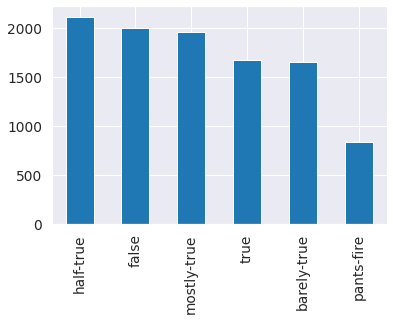

In [0]:
fake_data['label'].value_counts().plot(kind="bar")
plt.show()

In [0]:
fake_data.dtypes

id                    object
label                 object
statement             object
subject               object
speaker               object
speaker_title         object
state_info            object
party_affiliation     object
barely_true_count    float64
false_count          float64
half_true_count      float64
mostly_true_count    float64
pants_on_fire        float64
context               object
dtype: object

In [0]:
fake_data['subject_codes'] = fake_data['subject'].astype('category').cat.codes
fake_data['speaker_codes'] = fake_data['speaker'].astype('category').cat.codes
fake_data['party_affiliation_codes'] = fake_data['party_affiliation'].astype('category').cat.codes
fake_data['speaker_title_codes'] = fake_data['speaker_title'].astype('category').cat.codes
fake_data['label_codes'] = fake_data['label'].astype('category').cat.codes
fake_data['context_codes'] = fake_data['context'].astype('category').cat.codes

fake_data.head(2)

,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context,subject_codes,speaker_codes,party_affiliation_codes,speaker_title_codes,label_codes,context_codes
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,30,814,19,869,1,1313
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,2570,2491,5,867,2,1153


## Correlation Map

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 11 Text major ticklabel objects>)

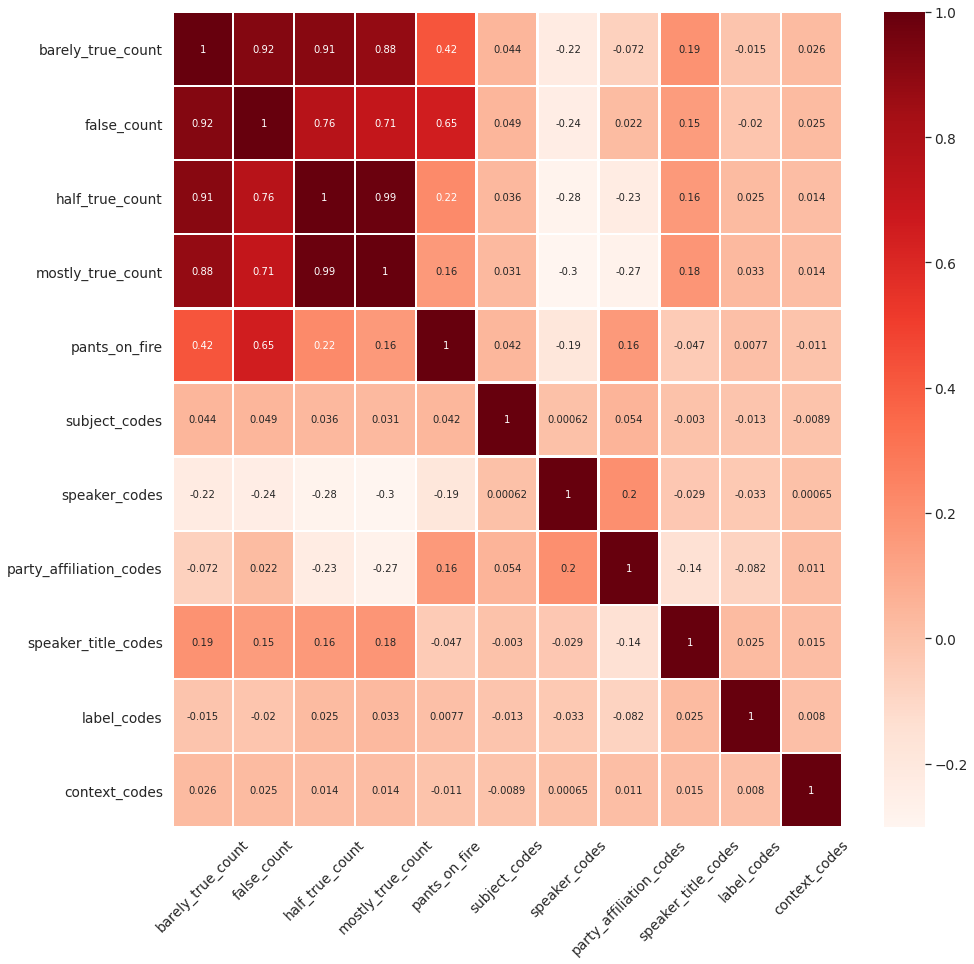

In [0]:
figure, axes = mp.subplots(figsize=(15,15))
sns.heatmap(fake_data.corr(), annot=True, vmax=1, linewidths=1.5, cmap='Reds')
mp.xticks(rotation=45)

## Processing complete data

In [0]:
from nltk.tokenize import word_tokenize


def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """

    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = text.split()
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
        
        text = ' '.join(word for word in text)

    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [0]:
fake_data['statement_processed'] = fake_data['statement'].apply(apply_all)


## Processing False news

Mostly commonly used word in false news

In [0]:
fake_data['label'].unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [0]:
false_data = fake_data[(fake_data['label'] == 'false') | (fake_data['label'] == 'pants-fire')]
true_data = fake_data[(fake_data['label'] == 'true') | (fake_data['label'] == 'mostly-true')]

In [0]:
print(false_data.head(2))
print(true_data.head(2))

          id  ...                                statement_processed
0  2635.json  ...  say anni list polit group support thirdtrimest...
3  1123.json  ...  health care reform legisl like mandat free sex...

[2 rows x 21 columns]
           id  ...                                statement_processed
2    324.json  ...  hillari clinton agre john mccain vote give geo...
5  12465.json  ...  chicago bear start quarterback last year total...

[2 rows x 21 columns]


In [0]:
stem_words(remove_stop_words(initial_clean('Hello How are you family anniversary world peace')))

'hello famili anniversari world peac'

## Remove punctuation and lower casing 

In [0]:
false_data['statement_processed'] = false_data['statement'].apply(apply_all)

false_data.head(2)

,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context,subject_codes,speaker_codes,party_affiliation_codes,speaker_title_codes,label_codes,context_codes,statement_processed
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,30,814,19,869,1,1313,say anni list polit group support thirdtrimest...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,3075,272,16,-1,1,1403,health care reform legisl like mandat free sex...


In [0]:
# Load the regular expression library
import re
# Remove punctuation
false_data['statement_processed'] = false_data['statement'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
false_data['statement_processed'] = false_data['statement_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
false_data['statement_processed'].head()

0     says the annies list political group supports ...
3     health care reform legislation is likely to ma...
12    when mitt romney was governor of massachusetts...
20    women and men both are making less when you ad...
25                 i dont know who (jonathan gruber) is
Name: statement_processed, dtype: object

## Word Cloud Visualization

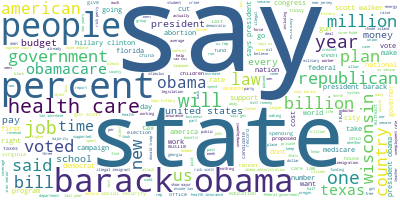

In [0]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(false_data['statement_processed'] .values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Prepare text for LDA Analysis

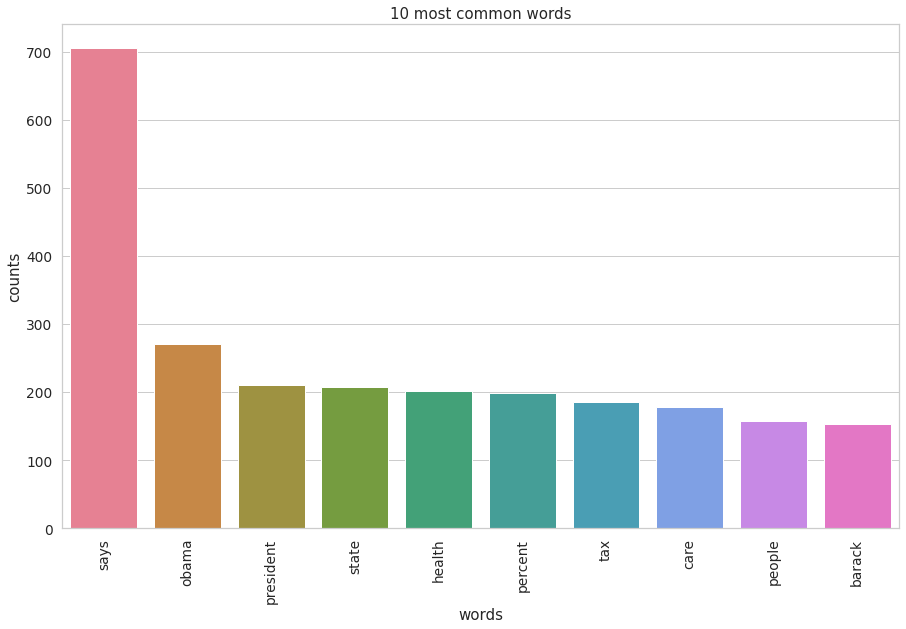

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(false_data['statement_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## Processing True News

In [0]:
# Load the regular expression library
import re
# Remove punctuation
true_data['statement_processed'] = true_data['statement'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
true_data['statement_processed'] = true_data['statement_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
true_data['statement_processed'].head()

2     hillary clinton agrees with john mccain "by vo...
5     the chicago bears have had more starting quart...
9     says gop primary opponents glenn grothman and ...
10    for the first time in history the share of the...
13    the economy bled $24 billion due to the govern...
Name: statement_processed, dtype: object

In [0]:
true_data['statement_processed'] = true_data['statement'].apply(apply_all)

true_data.head(2)

,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context,subject_codes,speaker_codes,party_affiliation_codes,speaker_title_codes,label_codes,context_codes,statement_processed
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,2863,182,5,642,3,79,hillari clinton agre john mccain vote give geo...
5,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,2311,2380,19,977,5,700,chicago bear start quarterback last year total...


## World cloud visualization - True news

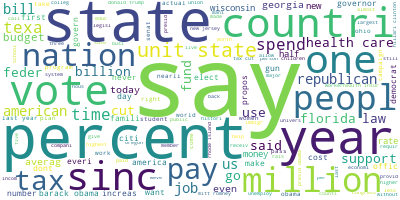

In [0]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(true_data['statement_processed'] .values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Prepare data for LDA Analysis

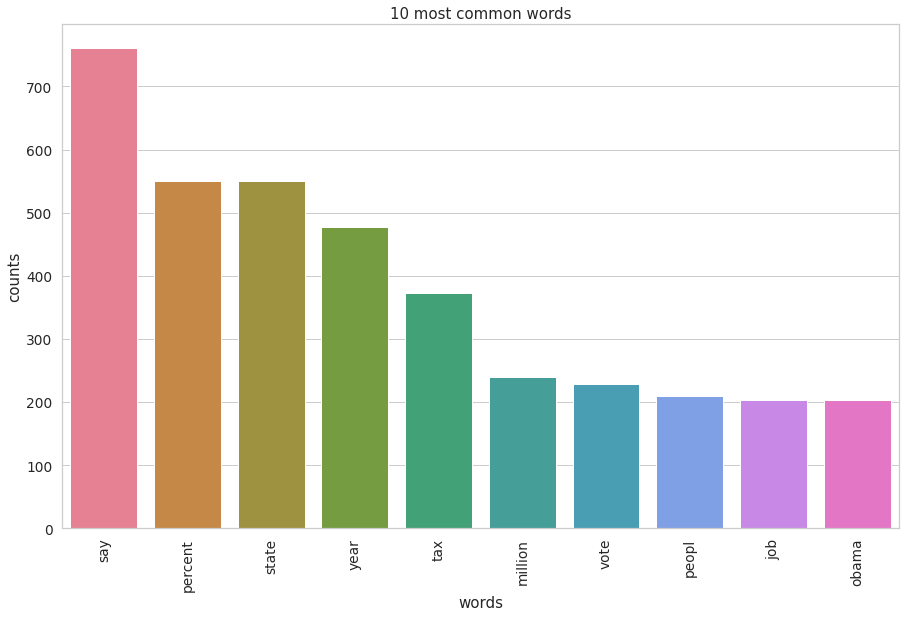

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(true_data['statement_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

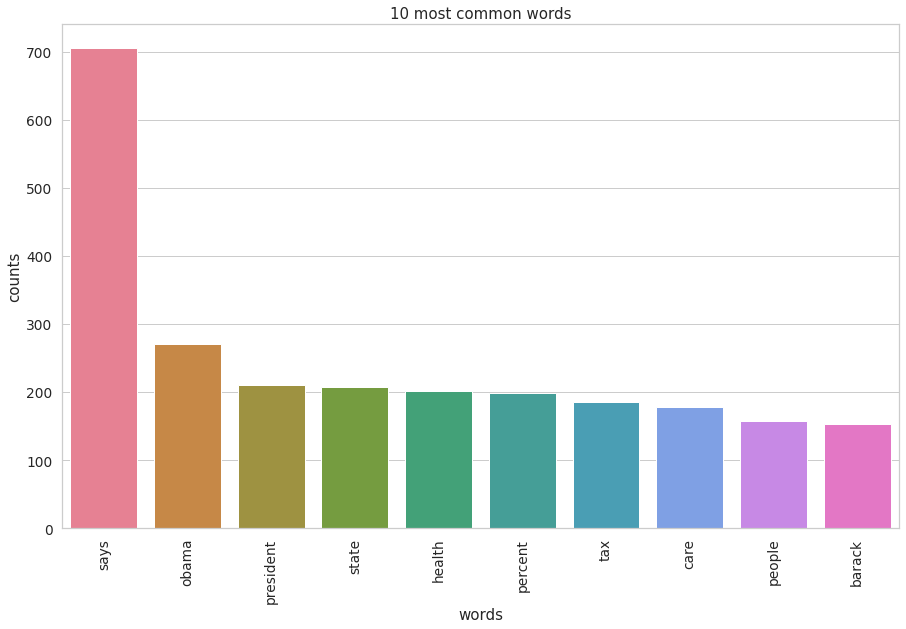

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(false_data['statement_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## Sentiment Analysis on News Article

In [0]:
fake_data.head(2)

,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context,subject_codes,speaker_codes,party_affiliation_codes,speaker_title_codes,label_codes,context_codes,statement_processed
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,30,814,19,869,1,1313,say anni list polit group support thirdtrimest...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,2570,2491,5,867,2,1153,declin coal start start natur ga took start be...


In [0]:
fake_data['negative'] = 0.0
fake_data['neutral'] = 0.0
fake_data['positive'] = 0.0

fake_data['compound'] = 0.0


In [0]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

headlines = fake_data['statement'].tolist()
ids = fake_data['id'].tolist()
for index in range(0,len(headlines)):
    line = headlines[index]
    if not pd.isna(line):
      pol_score = senti.polarity_scores(line)
      #print(pol_score)
      id = ids[index]
      fake_data.loc[fake_data['id'] == id, ['negative']] = pol_score['neg']# [neg,neu,pos,compound]
      fake_data.loc[fake_data['id'] == id, ['neutral']] = pol_score['neu']
      fake_data.loc[fake_data['id'] == id, ['positive']] = pol_score['pos']
      fake_data.loc[fake_data['id'] == id, ['compound']] = pol_score['compound']
      if index % 500 == 0:
        print("processing ",index,' of ',len(headlines))
      
fake_data.head(2)

processing  0  of  10240
processing  500  of  10240
processing  1000  of  10240
processing  1500  of  10240
processing  2000  of  10240
processing  2500  of  10240
processing  3000  of  10240
processing  3500  of  10240
processing  4000  of  10240
processing  4500  of  10240
processing  5000  of  10240
processing  5500  of  10240
processing  6000  of  10240
processing  6500  of  10240
processing  7000  of  10240
processing  7500  of  10240
processing  8000  of  10240
processing  8500  of  10240
processing  9000  of  10240
processing  9500  of  10240
processing  10000  of  10240


,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context,subject_codes,speaker_codes,party_affiliation_codes,speaker_title_codes,label_codes,context_codes,statement_processed,negative,neutral,positive,compound
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,30,814,19,869,1,1313,say anni list polit group support thirdtrimest...,0.115,0.692,0.192,0.2500
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,2570,2491,5,867,2,1153,declin coal start start natur ga took start be...,0.000,0.902,0.098,0.3612


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

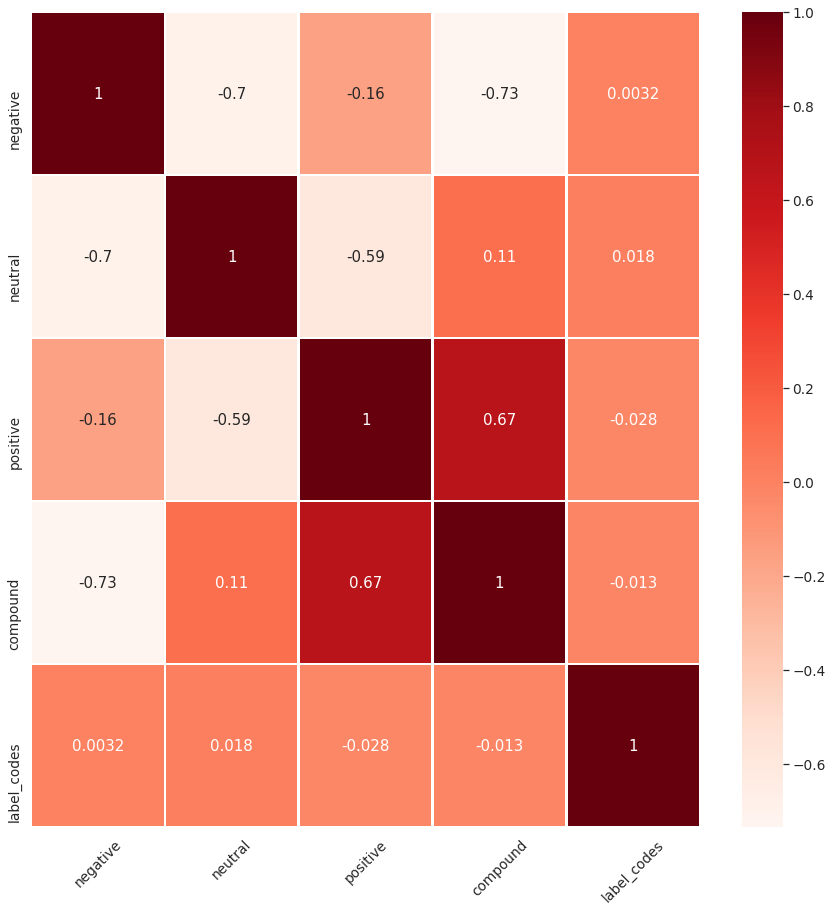

In [0]:
cols = ['negative','neutral','positive','compound','label_codes']

figure, axes = mp.subplots(figsize=(15,15))
sns.heatmap(fake_data[cols].corr(), annot=True, vmax=1, linewidths=1.5, cmap='Reds')
mp.xticks(rotation=45)

# Preprocessing Second dataset (Kaggle)


## Load dataset

In [0]:
# Load Dataset from drive
kaggle_data = pd.read_csv('/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/fake.csv', low_memory =False)
kaggle_data.head(2)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias


In [0]:
print(kaggle_data.shape)
kaggle_data.dtypes

(12999, 20)


uuid                   object
ord_in_thread           int64
author                 object
published              object
title                  object
text                   object
language               object
crawled                object
site_url               object
country                object
domain_rank           float64
thread_title           object
spam_score            float64
main_img_url           object
replies_count           int64
participants_count      int64
likes                   int64
comments                int64
shares                  int64
type                   object
dtype: object

## Find missing value

In [0]:
kaggle_data.isna().sum()

uuid                     0
ord_in_thread            0
author                2424
published                0
title                  680
text                    46
language                 0
crawled                  0
site_url                 0
country                176
domain_rank           4223
thread_title            12
spam_score               0
main_img_url          3643
replies_count            0
participants_count       0
likes                    0
comments                 0
shares                   0
type                     0
dtype: int64

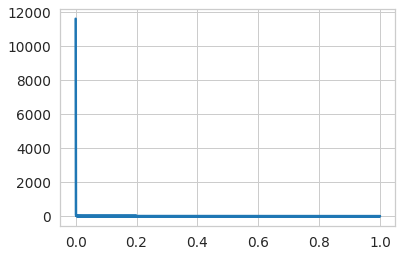

In [0]:
kaggle_data['spam_score'].value_counts().plot(kind="line")
plt.show()

In [0]:
kaggle_data[kaggle_data['title'] == kaggle_data['thread_title']]

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12908,613e1a6e130b5a3f5df62c8fb0b73667742a43db,0,NaN,2016-10-26T21:28:00.000+03:00,Tesla Earnings Smash Expectations After Dramat...,"Oct 26, 2016 4:26 PM 0 SHARES \nThere was a su...",english,2016-10-26T23:32:01.992+03:00,zerohedge.com,CH,2435.0,Tesla Earnings Smash Expectations After Dramat...,0.010,NaN,0,0,21,0,21,bs
12909,dedc36a34e5cb1062bf4627d314227f60cd9a708,0,Tyler Durden,2016-10-26T23:53:43.161+03:00,Rules For Rulers (Or How The World Really Works),"The following video is a must watch, particula...",english,2016-10-26T23:53:43.161+03:00,zerohedge.com,US,2435.0,Rules For Rulers (Or How The World Really Works),0.000,NaN,0,1,72,0,72,bs
12910,cd8bb1ae426287f3a63c2979b3b5dfb0277b10e2,0,George Washington,2016-10-26T23:53:49.879+03:00,Fact Check: Trump Is Right that Clinton Might ...,She explains : \nHillary Clinton wants to star...,english,2016-10-26T23:53:49.879+03:00,zerohedge.com,US,2435.0,Fact Check: Trump Is Right that Clinton Might ...,0.000,NaN,0,1,333,0,333,bs
12911,213eb9eeb5479ad2588b54b24acd53bc8ead8e8c,0,Tyler Durden,2016-10-27T00:20:00.111+03:00,Caught On Tape: ISIS Destroys Iraqi Abrams Wit...,"YHC-FTSE Oct 26, 2016 5:14 PM \nWould have bee...",english,2016-10-27T00:20:00.111+03:00,zerohedge.com,US,2435.0,Caught On Tape: ISIS Destroys Iraqi Abrams Wit...,0.000,NaN,0,1,197,0,197,bs


In [0]:
print(kaggle_data.shape)
kaggle_data_filtered = kaggle_data[kaggle_data['text'].notna()]
print(kaggle_data_filtered.shape)

(12999, 20)
(12953, 20)


In [0]:
kaggle_data_filtered['text_processed'] = kaggle_data_filtered['text'].apply(apply_all)

kaggle_data_filtered.head(2)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_processed
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,print pay back money plu interest entir famili...
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney gener loretta lynch plead fifth barra...


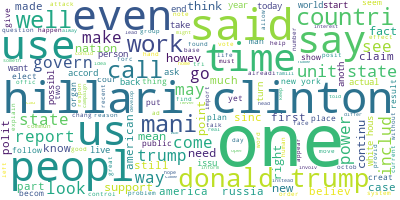

In [0]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(kaggle_data_filtered['text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

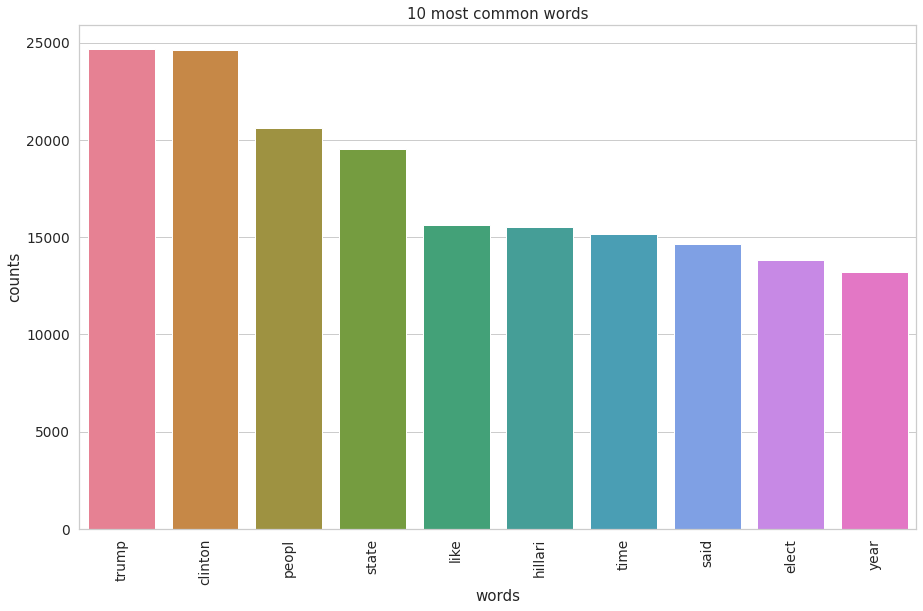

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(kaggle_data_filtered['text_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [0]:
kaggle_data_filtered['negative'] = 0.0
kaggle_data_filtered['neutral'] = 0.0
kaggle_data_filtered['positive'] = 0.0
kaggle_data_filtered['compound'] = 0.0


In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

headlines = kaggle_data_filtered['text_processed'].tolist()
ids = kaggle_data_filtered['uuid'].tolist()
for index in range(0,len(headlines)):
    line = headlines[index]
    if not pd.isna(line):
      pol_score = senti.polarity_scores(line)
      #print(pol_score)
      id = ids[index]
      kaggle_data_filtered.loc[kaggle_data_filtered['uuid'] == id, ['negative']] = pol_score['neg']# [neg,neu,pos,compound]
      kaggle_data_filtered.loc[kaggle_data_filtered['uuid'] == id, ['neutral']] = pol_score['neu']
      kaggle_data_filtered.loc[kaggle_data_filtered['uuid'] == id, ['positive']] = pol_score['pos']
      kaggle_data_filtered.loc[kaggle_data_filtered['uuid'] == id, ['compound']] = pol_score['compound']
      if index % 500 == 0:
        print("processing ",index,' of ',len(headlines))
      
kaggle_data_filtered.head(2)

processing  0  of  12953
processing  500  of  12953
processing  1000  of  12953
processing  1500  of  12953
processing  2000  of  12953
processing  2500  of  12953
processing  3000  of  12953
processing  3500  of  12953
processing  4000  of  12953
processing  4500  of  12953
processing  5000  of  12953
processing  5500  of  12953
processing  6000  of  12953
processing  6500  of  12953
processing  7000  of  12953
processing  7500  of  12953
processing  8000  of  12953
processing  8500  of  12953
processing  9000  of  12953
processing  9500  of  12953
processing  10000  of  12953
processing  10500  of  12953
processing  11000  of  12953
processing  11500  of  12953
processing  12000  of  12953
processing  12500  of  12953


,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_processed,negative,neutral,positive,compound
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,print pay back money plu interest entir famili...,0.199,0.625,0.176,-0.3400
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,attorney gener loretta lynch plead fifth barra...,0.080,0.872,0.048,-0.6908




* Speaker with maximum number of label
* 



In [0]:
fake_data.dtypes

id                          object
label                       object
statement                   object
subject                     object
speaker                     object
speaker_title               object
state_info                  object
party_affiliation           object
barely_true_count          float64
false_count                float64
half_true_count            float64
mostly_true_count          float64
pants_on_fire              float64
context                     object
subject_codes                int16
speaker_codes                int16
party_affiliation_codes       int8
speaker_title_codes          int16
label_codes                   int8
context_codes                int16
statement_processed         object
negative                   float64
neutral                    float64
positive                   float64
compound                   float64
dtype: object

In [0]:
kaggle_data_filtered.dtypes

uuid                   object
ord_in_thread           int64
author                 object
published              object
title                  object
text                   object
language               object
crawled                object
site_url               object
country                object
domain_rank           float64
thread_title           object
spam_score            float64
main_img_url           object
replies_count           int64
participants_count      int64
likes                   int64
comments                int64
shares                  int64
type                   object
text_processed         object
negative              float64
neutral               float64
positive              float64
compound              float64
dtype: object

In [0]:
fake_data[['label','label_codes']].head(10)

# false -1 - 0
# half -true = 2 -0
# mostly-true  3 -1
# pants-fire	4 -0
#barely-true	-0 - 0
#true=5 - 1

,label,label_codes
0,false,1
1,half-true,2
2,mostly-true,3
3,false,1
4,half-true,2
5,true,5
6,barely-true,0
7,half-true,2
8,half-true,2
9,mostly-true,3


In [0]:
fake_data[(fake_data['label_codes'] == 1)].head(2)

,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context,subject_codes,speaker_codes,party_affiliation_codes,speaker_title_codes,label_codes,context_codes,statement_processed,negative,neutral,positive,compound
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,30,814,19,869,1,1313,say anni list polit group support thirdtrimest...,0.115,0.692,0.192,0.2500
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,3075,272,16,-1,1,1403,health care reform legisl like mandat free sex...,0.000,0.606,0.394,0.7579


In [0]:
# false -1 - 0
# half -true = 2 -0
# mostly-true  3 -1
# pants-fire	4 -0
#barely-true	-0 - 0
#true=5 - 1

In [0]:
fake_data_ = fake_data.copy()
fake_data['fake_label'] = fake_data['label_codes'].apply(lambda x: 1 if (int(x) ==3 or int(x) == 5)  else 0)

In [0]:
kaggle_data_filtered.dtypes

uuid                   object
ord_in_thread           int64
author                 object
published              object
title                  object
text                   object
language               object
crawled                object
site_url               object
country                object
domain_rank           float64
thread_title           object
spam_score            float64
main_img_url           object
replies_count           int64
participants_count      int64
likes                   int64
comments                int64
shares                  int64
type                   object
text_processed         object
negative              float64
neutral               float64
positive              float64
compound              float64
dtype: object

In [0]:
np.mean(kaggle_data_filtered['spam_score'].values)

0.026214622095267506

In [0]:
meanValue = np.mean(kaggle_data_filtered['spam_score'].values)
kaggle_data_filtered['fake_label'] = kaggle_data_filtered['spam_score'].apply(lambda x: 0 if x <= meanValue else 1)

Intensionally, adding column published to match with other side

In [0]:
fake_data['published'] = kaggle_data_filtered['published'][0]

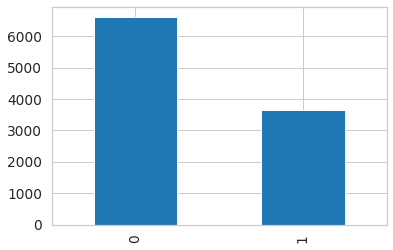

In [0]:
fake_data['fake_label'].value_counts().plot(kind="bar")
plt.show()

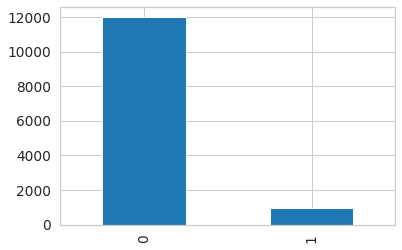

In [0]:
kaggle_data_filtered['fake_label'].value_counts().plot(kind="bar")
plt.show()

## Keyword extraction for dataset 1

## Load stopwords

In [0]:
def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
 
#load a set of stop words
stopwords=get_stop_words("/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/stopwords.txt")
print(len(stopwords))
char_splitter = re.compile("[.,;!:()-]")

752


### Computing TF-IDF and Extracting Keywords


In [0]:

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def get_keywords(text):

    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([text]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    
    return keywords   

In [0]:
docs = fake_data['statement_processed'].values
cv=CountVectorizer(max_df=0.85,stop_words=stopwords)
word_count_vector=cv.fit_transform(docs)

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [0]:
feature_names=cv.get_feature_names()

fake_data['keywords'] = fake_data['statement_processed'].apply(get_keywords)
fake_data['keywords']

0        {'anni': 0.476, 'thirdtrimest': 0.456, 'demand...
1        {'start': 0.68, 'coal': 0.28, 'natur': 0.274, ...
2        {'doubt': 0.433, 'agre': 0.345, 'iran': 0.303,...
3        {'surgeri': 0.467, 'sex': 0.362, 'mandat': 0.3...
4        {'turnaround': 0.608, 'start': 0.403, 'term': ...
                               ...                        
10235    {'shark': 0.503, 'larger': 0.393, 'fraud': 0.3...
10236    {'metro': 0.455, 'area': 0.413, 'becom': 0.39,...
10237    {'social': 0.397, 'secur': 0.377, 'galveston':...
10238    {'embargo': 0.467, 'cuban': 0.449, 'lift': 0.4...
10239    {'veteran': 0.429, 'manual': 0.322, 'stuff': 0...
Name: keywords, Length: 10240, dtype: object

In [0]:
fake_data.head(2)

,id,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire,context,subject_codes,speaker_codes,party_affiliation_codes,speaker_title_codes,label_codes,context_codes,statement_processed,negative,neutral,positive,compound,fake_label,published,keywords
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,30,814,19,869,1,1313,say anni list polit group support thirdtrimest...,0.115,0.692,0.192,0.2500,0,2016-10-26T21:41:00.000+03:00,"{'anni': 0.476, 'thirdtrimest': 0.456, 'demand..."
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,2570,2491,5,867,2,1153,declin coal start start natur ga took start be...,0.000,0.902,0.098,0.3612,0,2016-10-26T21:41:00.000+03:00,"{'start': 0.68, 'coal': 0.28, 'natur': 0.274, ..."


## Keyword extraction for dataset 2

In [0]:
docs = kaggle_data_filtered['text_processed'].values
cv=CountVectorizer(max_df=0.85,stop_words=stopwords)
word_count_vector=cv.fit_transform(docs)

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [0]:
tfidf_transformer.idf_


array([6.70795978, 9.08286554, 9.77601272, ..., 9.77601272, 8.67740043,
       9.77601272])

In [0]:
feature_names=cv.get_feature_names()

kaggle_data_filtered['keywords'] = kaggle_data_filtered['text_processed'].apply(get_keywords)
kaggle_data_filtered['keywords'][0]

{'asap': 0.261,
 'bust': 0.203,
 'deport': 0.191,
 'group': 0.192,
 'refugeesimmigr': 0.33,
 'scam': 0.202,
 'somali': 0.265,
 'stole': 0.219,
 'systemit': 0.341,
 'taxpay': 0.179}

## Amalgamanation


In [0]:
features_cols1 = ['id','subject','statement','fake_label','speaker','published','negative','neutral','positive','compound','keywords']
features_cols2 = ['uuid','title','text','fake_label','author','published','negative','neutral','positive','compound','keywords']

In [0]:
fake_data_df = fake_data[features_cols1]
kaggle_data_df = kaggle_data_filtered[features_cols2]
print('Liar Liar dataset shape: ',fake_data_df.shape)
print('Kaggle dataset shape: ',kaggle_data_df.shape)



Liar Liar dataset shape:  (10240, 11)
Kaggle dataset shape:  (12953, 11)


In [0]:
kaggle_data_df.columns = features_cols1
kaggle_data_df.head(2)

,id,subject,statement,fake_label,speaker,published,negative,neutral,positive,compound,keywords
0,6a175f46bcd24d39b3e962ad0f29936721db70db,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,0.199,0.625,0.176,-0.3400,"{'systemit': 0.341, 'refugeesimmigr': 0.33, 's..."
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,0.080,0.872,0.048,-0.6908,"{'lynch': 0.445, 'plead': 0.313, 'payment': 0...."


### Concatenate data 

In [0]:
df_fake = pd.concat([fake_data_df, kaggle_data_df], names=[features_cols1],ignore_index=True)
df_fake.reset_index()
df_fake.shape

(23193, 11)

In [0]:
df_fake.to_csv('Liar_kaggle_concat.csv')

In [0]:
df_fake.tail()

,id,subject,statement,fake_label,speaker,published,negative,neutral,positive,compound,keywords
23188,f1b5d0e44803f48732bde854a9fdf95837219b12,NaN,It DOES allow you to put a dog face on top of ...,0,replaceme,2016-10-26T23:58:00.000+03:00,0.0,0.709,0.291,0.4019,"{'dog': 0.625, 'face': 0.6, 'sound': 0.266, 't..."
23189,36011ceba3647e1bea78299b68b6fb705a1fc1ad,NaN,Wait till you see what happens to the valuatio...,0,Freedumb,2016-10-27T00:02:00.000+03:00,0.0,1.000,0.000,0.0000,"{'hamster': 0.543, 'valuat': 0.497, 'face': 0...."
23190,6995d1aa9ac99926106489b14b5530e85358059a,NaN,I'm waiting for the one that puts a pussy on m...,0,major major maj...,2016-10-27T00:06:00.000+03:00,0.0,1.000,0.000,0.0000,"{'pussi': 0.714, 'wait': 0.418, 'im': 0.35, 'f..."
23191,7de8ae90eee164eb756db6c8a3772288e11d7a94,NaN,$4 Billion even after they are known to be kee...,0,beemasters,2016-10-27T00:09:00.000+03:00,0.0,0.725,0.275,0.6908,"{'profitprob': 0.551, 'blackmail': 0.344, 'del..."
23192,dabef7095b7d9dae6eb0d83c4cbb40b85efd7ae5,NaN,of course - how else would they disceminate te...,0,i&#039;m-confused,2016-10-27T00:09:00.000+03:00,0.0,1.000,0.000,0.0000,"{'powrn': 0.56, 'discemin': 0.56, 'kiddi': 0.4..."


# Data Narrative

We started working with Liar Liar dataset and Kaggle Fake News dataset. We have huge imbalance in the fake and real news data from these two datasets. We did initial preprocessing on news article by 
* Removing stopwords
* Remove special character
* Remove punctuations
* Lowercase 
* Stemming 
* Lemmetization

We further analyzed the news articles sentiment using Vader Library and have included 4 additional features such as positive, negative, neutral and compound. We have used Tf-idf vectorizer to vistualize the least common and most common words in the corpus.
From Tf-idf vector, we have predicted the keywords for each corpus. We have amalgamated both the dataset. 

# Regression model

## Factor analysis

1. **Credibility-and-Reliability** : This factor focus on validating the creditibility  and reliability of news source from news articles. We have validated the sentiments and spellcheck for reliablility
    
2. **Biases** :  This factor focus on verifying the sentiment of news and detect biase factor 
3. **News Coverage**: This factor investigates news coverage of the same story in different media outlets and compare their coverage to predict the truthness of news
4. **Neural Micro-patterns-of-Misinformation**: This factor focuses on measuring the mispattern in the news article and detect the fakeness.

Each team member investigated the above factor and build a classification model, which helps to build a Regression model on Fake news detection. 



## Polynomial equation

From each factor classification model, we have individual accuracy scores

Factor | Algorithm | Accuracy
--- | --- | -----
Credibility-and-Reliability |Multinomial Bayes| 60%
Biases | Multinomial Bayes| 87%
News Coverage | Logistic Regression  | 75%
News Coverage | Linear Discriminant Analysis​(LDA) | 72%
News Coverage | Multinomial Bayes | 70%
News Coverage | Random Forest  | 72%
Neutral Micro-patterns-of-misinformation| Gradient Boosting Classifier|67%
Neutral Micro-patterns-of-misinformation| Random Forest Classifier|64%

**Regression Equation**:

Fakeness = 0.60 * (Credibility-and-Reliability) + 0.87 * (Biases) + 0.75 * (News Coverage) + 0.67 * (Neutral Micro-patterns-of-misinformation)


For this iteration ,we have used 4 factors and come up with the above accuracy for each factor to detect fakeness. We would like to include more factor analysis and improve the existing factors with more features.  


# Data Imbalance and Future work

During some specific factor analysis such as news coverage, neutral micro-patterns of misinformation, we have noticed the existing datasets doesn't have much features such as news source, availability of real news label, published date, source of news article etc.. Hence we have used some addition data sources for investigating factors. We will enrich the existing dataset with the news dataset in the upcoming week.

Additional Datasource
* ISOT news articles 
* Kaggle All news dataset
* Toxic News Dataset

## References

* http://kavita-ganesan.com/how-to-incorporate-phrases-into-word2vec-a-text-mining-approach/#.Xpp1apNKhYh
* https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py
* https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5
* https://medium.com/@adriensieg/text-similarities-da019229c894 
* https://www.kaggle.com/ktattan/lda-and-document-similarity 
* https://snap.stanford.edu/mis2/files/MIS2_paper_17.pdf
* https://github.com/several27/FakeNewsCorpus